In [1]:
import cv2
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing import image

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [3]:
base_dir = './pattern_train_base/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [4]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,7))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_sampel = 3101

train_features, train_labels = extract_features(train_dir, train_sampel) #5096

Found 3101 images belonging to 7 classes.


In [6]:
validation_sample = 1550

validation_features, validation_labels = extract_features(validation_dir, validation_sample) # 2548

Found 1550 images belonging to 7 classes.


In [7]:
test_sample = 1553

test_features, test_labels = extract_features(test_dir, test_sample) #2547

Found 1553 images belonging to 7 classes.


In [8]:
train_features = np.reshape(train_features,(train_sampel, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(validation_sample, 4 * 4 * 512))
test_features = np.reshape(test_features,(test_sample, 4 * 4 * 512))

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_pattern_0424.h5', monitor='val_loss', mode='min', save_best_only=True)

In [10]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
                         loss='categorical_crossentropy',
                         metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,
                   epochs=500,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels),
                   callbacks=[es,mc])

Train on 3101 samples, validate on 1550 samples
Epoch 1/500
3101/3101 [==============================] - 4s 1ms/step - loss: 1.7046 - acc: 0.3554 - val_loss: 1.2710 - val_acc: 0.6626
Epoch 2/500
3101/3101 [==============================] - 4s 1ms/step - loss: 1.0671 - acc: 0.6553 - val_loss: 0.9157 - val_acc: 0.7652
Epoch 3/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.7435 - acc: 0.7788 - val_loss: 0.7529 - val_acc: 0.7787
Epoch 4/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.6005 - acc: 0.8197 - val_loss: 0.6622 - val_acc: 0.8052
Epoch 5/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.5002 - acc: 0.8533 - val_loss: 0.6024 - val_acc: 0.8142
Epoch 6/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.4578 - acc: 0.8617 - val_loss: 0.5801 - val_acc: 0.8161
Epoch 7/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.4030 - acc: 0.8794 - val_loss: 0.5425 - val_acc: 0.8232
Epoch 8

Epoch 61/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0230 - acc: 0.9965 - val_loss: 0.5084 - val_acc: 0.8581
Epoch 62/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0272 - acc: 0.9948 - val_loss: 0.4980 - val_acc: 0.8568
Epoch 63/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0245 - acc: 0.9977 - val_loss: 0.4962 - val_acc: 0.8561
Epoch 64/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0243 - acc: 0.9968 - val_loss: 0.4790 - val_acc: 0.8600
Epoch 65/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0203 - acc: 0.9971 - val_loss: 0.4905 - val_acc: 0.8626
Epoch 66/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0205 - acc: 0.9974 - val_loss: 0.4927 - val_acc: 0.8568
Epoch 67/500
3101/3101 [==============================] - 4s 1ms/step - loss: 0.0217 - acc: 0.9968 - val_loss: 0.4979 - val_acc: 0.8548
Epoch 68/500
3101/3101 [========================

In [15]:
model.save('pattern_0427.h5')

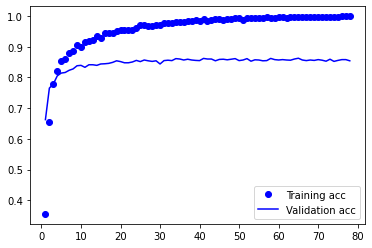

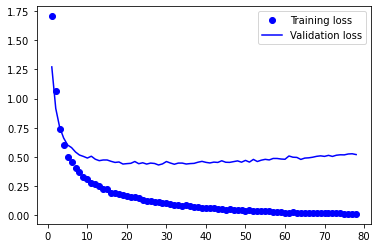

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
# plt.tilte('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
# plt.tilte('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save_weights('pattern_weights_0427.h5')